# Collect Mineral Shards

**Task**: 2 marines at disposition, map full of mineral shards, you need to select the marines and click on all mineral shards to collect them.

**Development objectives**:
1. Have a single agent architecture that can solve both games (it's okay to pass set-up options during initialization)
2. Pre-process up to all screen layers (each of them might have different needs, e.g. OHE)
3. Make sure that micromanagement strategies can be applied by selecting and moving also a single unit at the time, instead of all the army.
4. Make it easily scalable to other minigames (as little hard-coding as possible)

# Custom state representation
Idea: select layer names from screen that you need (think also about those on the minimap!) and pre-process only them. Then return number of channels and an object state that can be interpeted for visualization purposes (i.e. name each channel somehow, so that we can access them also by name and we don't mess up things when two channels in two different minigames are in different positions).

Starting example used only for move to beacon:
```python
def get_6chan_ohe_state(obs):
    feature_screen = obs[0].observation['feature_screen']
    
    player_relative_idx = feature_screen._index_names[0]['player_relative']
    player_relative = feature_screen[player_relative_idx]
    
    state = np.zeros((6,)+player_relative.shape).astype(float)
    
    friendly = (player_relative == _PLAYER_FRIENDLY).astype(float)
    neutral = (player_relative == _PLAYER_NEUTRAL).astype(float)
    state[0] = friendly
    state[1] = neutral
    
    layer_names = ['selected', 'visibility_map', 'unit_density', 'unit_density_aa']
    for i in range(len(layer_names)):
        layer_idx = feature_screen._index_names[0][layer_names[i]]
        state[i+2] = feature_screen[layer_idx].astype(float)

    return state
```

In [1]:
import sys
sys.path.insert(0, "../")

from SC_Utils.game_utils import init_game

from pysc2.lib import features
import numpy as np
import matplotlib.pyplot as plt

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
RESOLUTION = 64
MAX_STEPS = 256
game_params = dict(feature_screen=RESOLUTION, feature_minimap=64, action_space="FEATURES") 
game_names = {1:'MoveToBeacon',
              2:'CollectMineralShards',
              3:'DefeatRoaches',
              4:'FindAndDefeatZerglings',
              5:'DefeatZerglingsAndBanelings',
              6:'CollectMineralsAndGas',
              7:'BuildMarines'
              }
map_name = game_names[2]

In [3]:
env = init_game(game_params, map_name=map_name, max_steps=MAX_STEPS, random_seed=1)

In [4]:
obs = env.reset()

In [5]:
class ObsProcesser():
    def __init__(self, screen_names=[], minimap_names=[], select_all=False):
        
        self.screen_var = { 'height_map': (0,'unknown'), 
                            'visibility_map': (1,'ohe', 1), 
                            'creep': (2,'unknown'), 
                            'power': (3,'unknown'), 
                            'player_id': (4,'ohe', 3), # 1,2,16
                            'player_relative': (5,'ohe', 3), # friendly (1), neutral (3), enemy (4)
                            'unit_type': (6,'ohe', 9), # dependent on the number of minigames considered and unit in them 
                            'selected': (7,'ohe', 1),
                            'unit_hit_points': (8,'log'), 
                            'unit_hit_points_ratio': (9,'log'), 
                            'unit_energy': (10,'unknown'), 
                            'unit_energy_ratio': (11,'unknown'), 
                            'unit_shields': (12,'unknown'),
                            'unit_shields_ratio': (13, 'unknown'),
                            'unit_density': (14, 'float'), 
                            'unit_density_aa': (15, 'float'),
                            'effects': (16, 'unknown'),
                            'hallucinations': (17, 'unknown'),
                            'cloaked': (18, 'unknown'),
                            'blip': (19, 'unknown'),
                            'buffs': (20, 'unknown'), 
                            'buff_duration': (21, 'unknown'),  
                            'active': (22, 'unknown'), 
                            'build_progress': (23, 'unknown'), 
                            'pathable': (24, 'ohe', 1),  
                            'buildable': (25, 'ohe', 1),  
                            'placeholder': (26, 'unknown')}
        
        self.minimap_var = {'height_map': (0,'unknown'),
                            'visibility_map': (1, 'ohe', 1),
                            'creep': (2, 'unknown'), 
                            'camera': (3, 'ohe', 1), 
                            'player_id': (4, 'ohe', 3),
                            'player_relative': (5, 'ohe', 3),
                            'selected': (6,'ohe', 1),  
                            'unit_type': (7,'unknown'),
                            'alerts': (8, 'unknown'),
                            'pathable': (9, 'ohe', 1),  
                            'buildable': (10,'ohe', 1)}
        
        # Contains specifics both for screen and minimap
        self.categorical_specs = {
                                  'visibility_map':np.array([2]),
                                  'player_id':np.array([1,2,16]),
                                  'player_relative':np.array([1,3,4]),
                                  'unit_type':np.array([9, 18, 48, 105, 110, 317, 341, 342, 1680]),
                                  'selected':np.array([1]),
                                  'pathable':np.array([1]),
                                  'buildable':np.array([1]),
                                  'camera':np.array([1])
                                 }
        if select_all:
            # overrides layer_names selecting all known layers
            self.screen_names = [k for k in self.screen_var.keys() if self.screen_var[k][1] != 'unknown']
            self.minimap_names = [k for k in self.minimap_var.keys() if self.minimap_var[k][1] != 'unknown']
        else:
            # names of the layers to be selected
            self.screen_names = screen_names 
            self.minimap_names = minimap_names 
       
        self.screen_indexes =[self.screen_var[n][0] for n in self.screen_names]
        self.minimap_indexes =[self.minimap_var[n][0] for n in self.minimap_names]
        
    def get_state(self, obs):
        feature_screen = obs[0].observation['feature_screen']
        feature_minimap = obs[0].observation['feature_minimap']
        
        screen_layers, screen_names = self._process_screen_features(feature_screen)
        minimap_layers, minimap_names = self._process_minimap_features(feature_minimap)
        state = {'screen_layers':screen_layers, 'minimap_layers':minimap_layers}
        names = {'screen_names':screen_names, 'minimap_names':minimap_names}
        return state, names
    
    def _process_screen_features(self, feature_screen):
        names = list(feature_screen._index_names[0].keys())
        processed_layers = []
        processed_names = []

        for i, idx in enumerate(self.screen_indexes):
            try:
                assert names[idx] == self.screen_names[i], 'Mismatched state indexes'
            except:
                print('Mismatched state indexes')
                print('names[%d]'%idx, names[idx])
                print('self.screen_names[%d]'%i, self.screen_names[i])
                
            layer = np.array(feature_screen[idx])
            if self.screen_var[names[idx]][1] == 'ohe':
                layer, name = self._process_ohe_layer(layer, names[idx])
            elif self.screen_var[names[idx]][1] == 'float':
                layer, name = self._process_float_layer(layer, names[idx])
            elif self.screen_var[names[idx]][1] == 'log':
                layer, name = self._process_log_layer(layer, names[idx])
            else:
                raise Exception('Type of layer '+names[idx]+' not understood')
                
            processed_layers.append(layer)
            processed_names.append(name)
        if len(processed_layers) > 0:
            processed_layers = np.concatenate(processed_layers).astype(float)
            processed_names = np.concatenate(processed_names)
        return processed_layers, processed_names
    
    def _process_minimap_features(self, feature_minimap):
        names = list(feature_minimap._index_names[0].keys())
        processed_layers = []
        processed_names = []

        for i, idx in enumerate(self.minimap_indexes):
            try:
                assert names[idx] == self.minimap_names[i], 'Mismatched state indexes'
            except:
                print('Mismatched state indexes')
                print('names[%d]'%idx, names[idx])
                print('self.minimap_names[%d]'%i, self.minimap_names[i])
                
            layer = np.array(feature_minimap[idx])
            if self.minimap_var[names[idx]][1] == 'ohe':
                layer, name = self._process_ohe_layer(layer, names[idx])
            elif self.minimap_var[names[idx]][1] == 'float':
                layer, name = self._process_float_layer(layer, names[idx])
            elif self.minimap_var[names[idx]][1] == 'log':
                layer, name = self._process_log_layer(layer, names[idx])
            else:
                raise Exception('Type of layer '+names[idx]+' not understood')
                
            processed_layers.append(layer)
            processed_names.append(name)
        if len(processed_layers) > 0:
            processed_layers = np.concatenate(processed_layers).astype(float)
            processed_names = np.concatenate(processed_names)
        return processed_layers, processed_names
    
    def _process_ohe_layer(self, layer, name):
        u = np.unique(layer)
        unique = u[u!=0] # 0 is always the background value, it doesn't get a dedicated layer
        possible_values = self.categorical_specs[name]
        try:
            assert np.all(np.isin(unique, possible_values))
        except:
            print("Found unexpected value in "+name+" layer")
            print("Expected possible values: \n", possible_values)
            print("Actual unique values (0 excl.): \n", unique)
        ohe_layer = (layer == possible_values.reshape(-1,1,1)).astype(float) # mask broadcasting + casting to float
        names = np.array([name+'_'+str(x) for x in possible_values]) 
        return ohe_layer, names

    def _process_float_layer(self, layer, name):
        return layer.reshape((1,)+layer.shape[-2:]).astype(float), [name]
    
    def _process_log_layer(self, layer, name):
        """Apply log2 to all nonzero elements"""
        mask = (layer!=0) 
        layer[mask] = np.log2(layer[mask])
        return layer.reshape((1,)+layer.shape[-2:]).astype(float), [name]

In [6]:
def assertion_test(actual, expected, error_msg=''):
    try:
        assert np.all(actual == expected)
    except:
        print(error_msg)
        print("Expected: \n", expected)
        print("Actual: \n", actual)
    return
        
def test_ObsProcesser(map_num=3):
    ### Test1 - select_all ###
    op1 = ObsProcesser(select_all=True)
    actual = np.array(op1.screen_names)
    expected = np.array(['visibility_map','player_id','player_relative','unit_type','selected','unit_hit_points',
               'unit_hit_points_ratio','unit_density','unit_density_aa','pathable','buildable'])
    assertion_test(actual, expected, "select_all (screen) test failed.")
 
    actual = np.array(op1.minimap_names)
    expected = np.array(['visibility_map','camera', 'player_id','player_relative','selected', 'pathable', 'buildable'])
    assertion_test(actual, expected, "select_all (minimap) test failed.")
    
    ### Test 2 - screen_names / minimap_names ###
    screen_names = ['visibility_map','player_relative','unit_type','unit_hit_points','selected'] 
    minimap_names = ['visibility_map','camera','pathable']
    op2 = ObsProcesser(screen_names, minimap_names)
    
    actual = np.array(op2.screen_names)
    expected = np.array(screen_names)
    assertion_test(actual, expected, "screen_names test failed.")
    
    actual = np.array(op2.minimap_names)
    expected = np.array(minimap_names)
    assertion_test(actual, expected, "minimap_names test failed.")
    
    ### Test 3 - screen_indexes / minimap_indexes ###
    actual = np.array(op2.screen_indexes)
    expected = np.array([1,5,6,8,7])
    assertion_test(actual, expected, "screen_indexes test failed.")    
    
    actual = np.array(op2.minimap_indexes)
    expected = np.array([1,3,9])
    assertion_test(actual, expected, "minimap_indexes test failed.")  
    
    ### Test 4 - state['screen_layers'] / state['minimap_layers'] shape ###
    RESOLUTION = 64
    MAX_STEPS = 256
    game_params = dict(feature_screen=RESOLUTION, feature_minimap=RESOLUTION, action_space="FEATURES") 
    game_names = {1:'MoveToBeacon',
                  2:'CollectMineralShards',
                  3:'DefeatRoaches',
                  4:'FindAndDefeatZerglings',
                  5:'DefeatZerglingsAndBanelings',
                  6:'CollectMineralsAndGas',
                  7:'BuildMarines'
                  }
    map_name = game_names[map_num]
    env = init_game(game_params, map_name=map_name, max_steps=MAX_STEPS, random_seed=1)
    obs = env.reset()
    state, names = op2.get_state(obs)
    
    expected = (15, RESOLUTION, RESOLUTION)
    actual = state['screen_layers'].shape
    assertion_test(actual, expected, "state shape (screen) test failed.")  
   
    expected = (3, RESOLUTION, RESOLUTION)
    actual = state['minimap_layers'].shape
    assertion_test(actual, expected, "state shape (minimap) test failed.")  
    
    ### Test 5 - names['screen_names'] / names['minimap_names']
    expected = np.array(['visibility_map_2','player_relative_1', 'player_relative_3', 'player_relative_4',
                         'unit_type_9', 'unit_type_18', 'unit_type_48', 'unit_type_105', 'unit_type_110', 
                         'unit_type_317','unit_type_341', 'unit_type_342', 'unit_type_1680','unit_hit_points', 
                         'selected_1'])
    actual = names['screen_names']
    assertion_test(actual, expected, "screen names test failed.")  

    expected = np.array(['visibility_map_2','camera_1','pathable_1'])
    actual = names['minimap_names']
    assertion_test(actual, expected, "minimap names test failed.")  
        
    return 0

In [7]:
test_ObsProcesser()

0

In [8]:
op = ObsProcesser(select_all=True)

In [9]:
state, names = op.get_state(obs)

In [10]:
state['screen_layers'].shape

(23, 64, 64)

In [11]:
state['minimap_layers'].shape

(11, 64, 64)

In [12]:
def merge_screen_and_minimap(state_dict):
    screen = state_dict['screen_layers']
    minimap = state_dict['minimap_layers']
    try:
        assert screen.shape[-2:] == minimap.shape[-2:], 'different resolutions'
    except:
        print("Shape mismatch between screen and minimap. They must have the same resolution.")
        print("Screen resolution: ", screen.shape[-2:])
        print("Minimap resolution: ", minimap.shape[-2:])
    
    state = np.concatenate([screen, minimap])
    return state

In [14]:
full_state = merge_screen_and_minimap(state)
full_state.shape

(34, 64, 64)

In [16]:
names['screen_names']

array(['visibility_map_2', 'player_id_1', 'player_id_2', 'player_id_16',
       'player_relative_1', 'player_relative_3', 'player_relative_4',
       'unit_type_9', 'unit_type_18', 'unit_type_48', 'unit_type_105',
       'unit_type_110', 'unit_type_317', 'unit_type_341', 'unit_type_342',
       'unit_type_1680', 'selected_1', 'unit_hit_points',
       'unit_hit_points_ratio', 'unit_density', 'unit_density_aa',
       'pathable_1', 'buildable_1'], dtype='<U21')

In [17]:
names['minimap_names']

array(['visibility_map_2', 'camera_1', 'player_id_1', 'player_id_2',
       'player_id_16', 'player_relative_1', 'player_relative_3',
       'player_relative_4', 'selected_1', 'pathable_1', 'buildable_1'],
      dtype='<U17')

In [52]:
np.where(names['screen_names']=='visibility_map_2')

(array([0]),)

Things to do:
1. Choose your own layers (both from map and minimap)
2. If not specified otherwise (e.g. select_all==True), select from the environment all the layers corresponding to those names
3. Map them in a meaningful way (ohe if cathegorical, float if numerical but with very limited range, log2 if numerical with many orders of magnitude)

In [148]:
layer = np.array([np.eye(5)+np.ones((5,5))*3-np.eye(5)[::-1,:]*2])
layer = layer.reshape(5,5)
print(layer.shape)

(5, 5)


In [154]:
layer = layer.reshape((1,)+layer.shape[-2:]).astype(float)
layer.shape

(1, 5, 5)

In [149]:
possible_values = np.array([1,3,4,5])

In [157]:
ohe_layer = (layer == possible_values.reshape(-1,1,1)).astype(float)*4

In [158]:
mask = (ohe_layer!=0)
ohe_layer[mask] = np.log2(ohe_layer[mask])
ohe_layer

array([[[0., 0., 0., 0., 2.],
        [0., 0., 0., 2., 0.],
        [0., 0., 0., 0., 0.],
        [0., 2., 0., 0., 0.],
        [2., 0., 0., 0., 0.]],

       [[0., 2., 2., 2., 0.],
        [2., 0., 2., 0., 2.],
        [2., 2., 0., 2., 2.],
        [2., 0., 2., 0., 2.],
        [0., 2., 2., 2., 0.]],

       [[2., 0., 0., 0., 0.],
        [0., 2., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 2., 0.],
        [0., 0., 0., 0., 2.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]])

In [169]:
x = np.concatenate([layer,ohe_layer])
x.shape

(5, 5, 5)

In [83]:
layer_names = ['player_relative']

In [32]:
feature_screen = obs[0].observation['feature_screen']
feature_minimap = obs[0].observation['feature_minimap']

In [37]:
layers_selected = []
for i in range(len(layer_names)):
    layer_idx = feature_screen._index_names[0][layer_names[i]]
    layers_selected.append(feature_screen[layer_idx])

In [38]:
layers_selected[0].dtype

dtype('int32')

In [39]:
np.nonzero(layers_selected[0]==1)

(array([2, 5]), array([7, 3]))

In [40]:
# this is just telling us the shape of the various observable variables, but not the range of their values!
env.observation_spec()[0]

{'action_result': (0,),
 'alerts': (0,),
 'build_queue': (0, 7),
 'cargo': (0, 7),
 'cargo_slots_available': (1,),
 'control_groups': (10, 2),
 'game_loop': (1,),
 'last_actions': (0,),
 'map_name': (0,),
 'multi_select': (0, 7),
 'player': (11,),
 'production_queue': (0, 2),
 'score_cumulative': (13,),
 'score_by_category': (11, 5),
 'score_by_vital': (3, 3),
 'single_select': (0, 7),
 'available_actions': (0,),
 'feature_screen': (27, 16, 16),
 'feature_minimap': (11, 16, 16),
 'upgrades': (0,),
 'home_race_requested': (1,),
 'away_race_requested': (1,)}

In [28]:
feature_screen.shape

(27, 16, 16)

In [29]:
#chosen_screen_index = [0, 1, 2, 3, 5, 6, 14, 15]
#chosen_minimap_index = [0, 1, 2, 5]

Example of preprocessing:

https://github.com/dai-dao/StarCraftBot/blob/master/rl/pre_processing.py

'height_map': 0, 'visibility_map': 1, 'creep': 2, 'power': 3, 'player_id': 4, 'player_relative': 5, 'unit_type': 6, 'selected': 7, 'unit_hit_points': 8, 'unit_hit_points_ratio': 9, 'unit_energy': 10, 'unit_energy_ratio': 11, 'unit_shields': 12, 'unit_shields_ratio': 13, 'unit_density': 14, 'unit_density_aa': 15, 'effects': 16, 'hallucinations': 17, 'cloaked': 18, 'blip': 19, 'buffs': 20, 'buff_duration': 21, 'active': 22, 'build_progress': 23, 'pathable': 24, 'buildable': 25, 'placeholder': 26

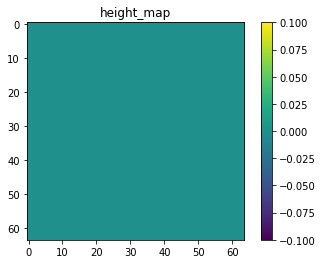

[0]


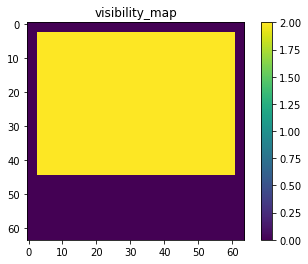

[0 2]


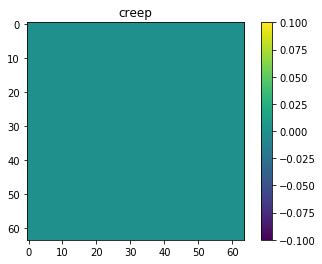

[0]


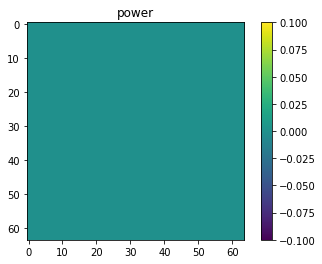

[0]


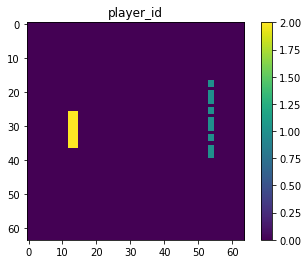

[0 1 2]


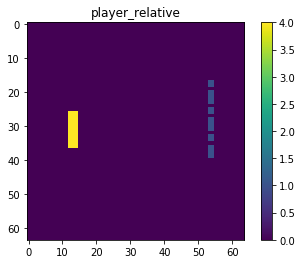

[0 1 4]


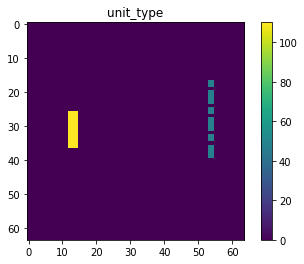

[  0  48 110]


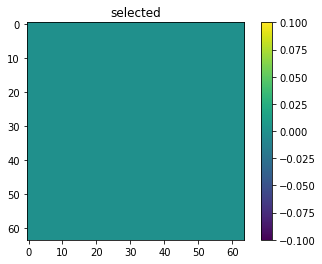

[0]


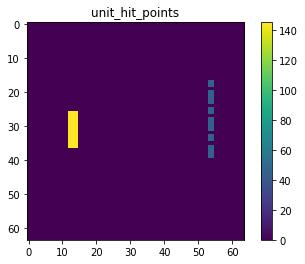

[  0  45 145]


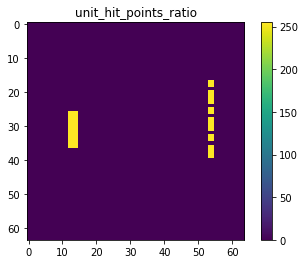

[  0 255]


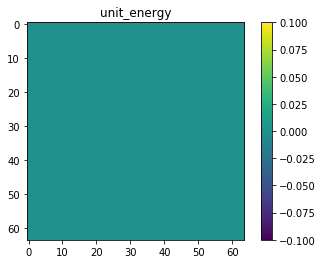

[0]


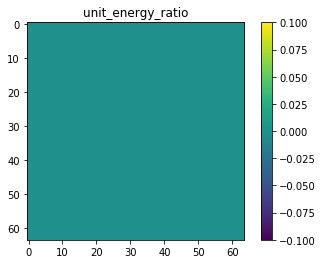

[0]


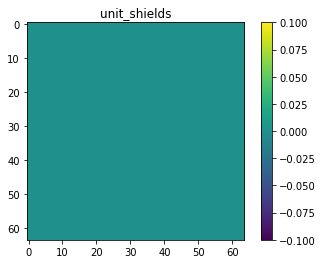

[0]


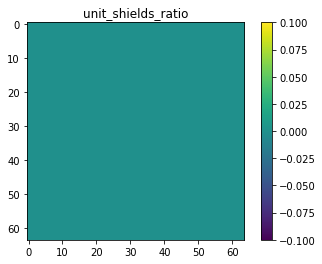

[0]


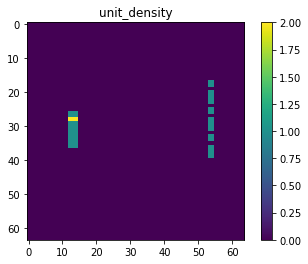

[0 1 2]


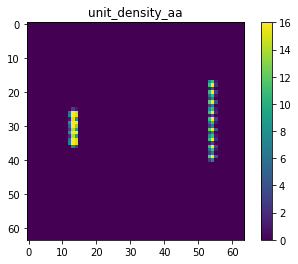

[ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16]


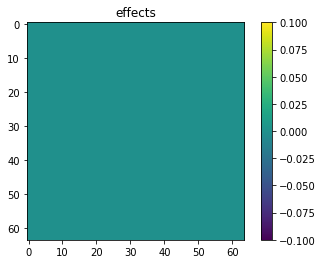

[0]


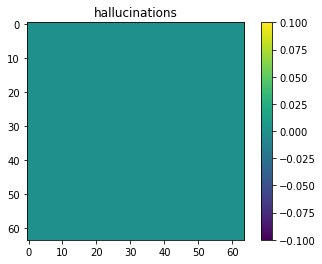

[0]


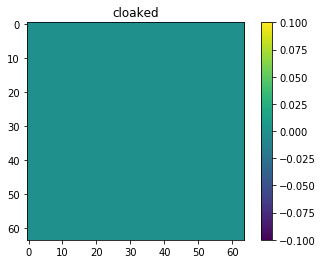

[0]


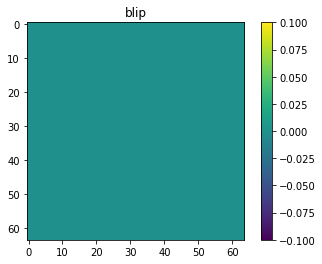

[0]


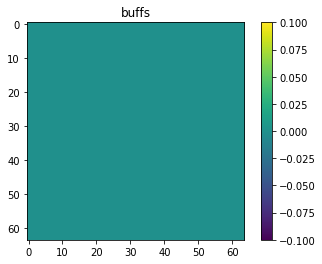

[0]


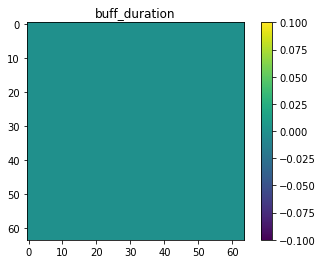

[0]


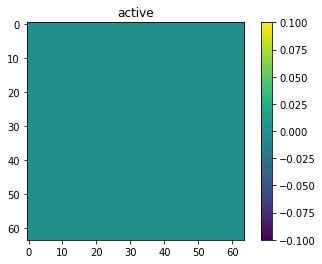

[0]


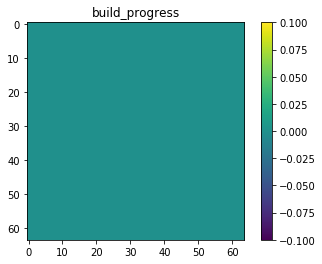

[0]


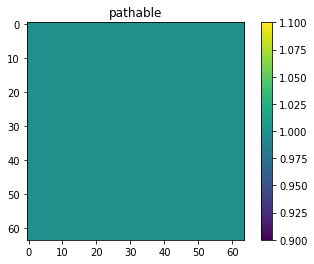

[1]


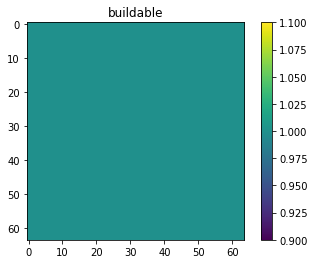

[1]


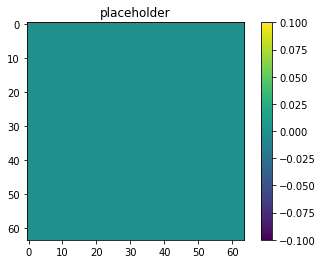

[0]


In [85]:
names = list(feature_screen._index_names[0])
for i,l in enumerate(feature_screen):
    l = np.array(l)
    plt.imshow(l)
    plt.title(names[i])
    plt.colorbar()
    plt.show()
    print(np.unique(l))

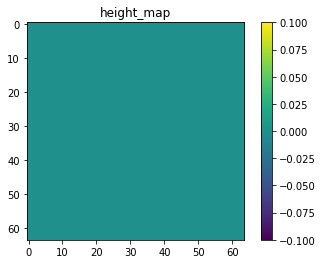

[0]


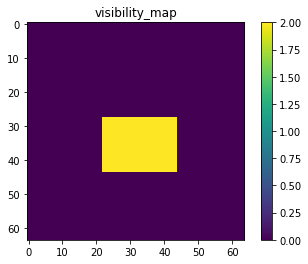

[0 2]


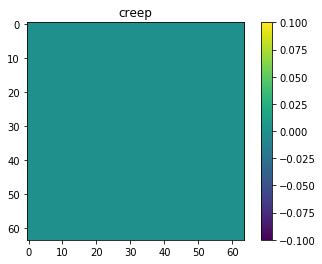

[0]


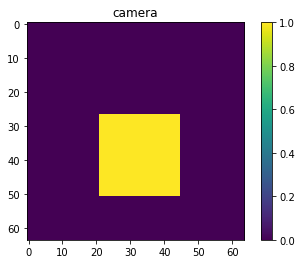

[0 1]


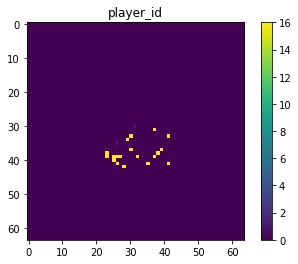

[ 0  1 16]


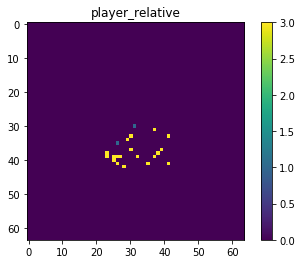

[0 1 3]


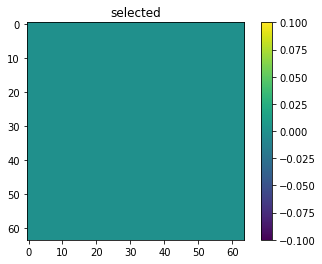

[0]


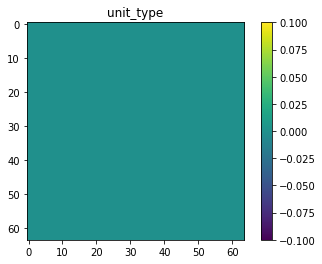

[0]


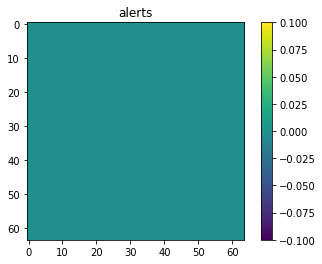

[0]


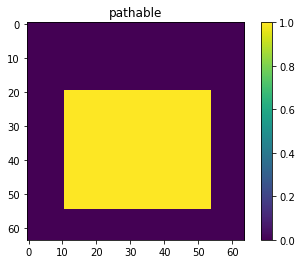

[0 1]


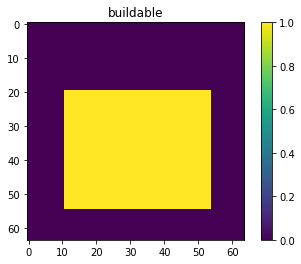

[0 1]


In [33]:
names = list(feature_minimap._index_names[0])
for i,l in enumerate(feature_minimap):
    l = np.array(l)
    plt.imshow(l)
    plt.title(names[i])
    plt.colorbar()
    plt.show()
    print(np.unique(l))

## Example -> make a test out of it

In [7]:
layer_names=['visibility_map','player_relative','unit_type','unit_hit_points'] # layers that I want to use
select_all=False

Use a flag that raises an error if a categorical value not expected is encountered during the game (for each categorical layer)